In [1]:
import os
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.models import Model
import pickle as pk
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import keras

In [2]:
model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    pooling = 'avg'
                   )

print(model.summary())

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │          0 │ conv2_block1_pre… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, None,      │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, None,      │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

None


In [4]:
#load captions from features
dir = 'D:/Tamal/internship/internship_project/Image_Captioning/dataset/captions.txt'
with open(dir, 'r') as cap:
    captions = cap.read()

In [53]:
#Feature extraction from images
from tqdm import tqdm
def feature_gather():
    feature_info = {}
    dir = "D:/Tamal/internship/internship_project/Image Captioning/dataset/Images"
    for i in tqdm(os.listdir(dir)):
        
        image = load_img(os.path.join(dir, i), target_size=(224, 224))
        image = img_to_array(image)/255.0
        image = image.reshape((1, 224, 224, 3))        
        image = preprocess_input(image)
        temp = model.predict(image, verbose=0)
        feature_info[i.split('.')[0]] = temp
        # print(i.split('.')[0])
    return feature_info
        


In [55]:
feature_gathered = feature_gather()

In [5]:

#Saving the features, what I extract from images
pk.dump(feature_gathered, open('feature_gathered.pkl', 'wb'))

In [3]:
feature_gathered = pk.load(open('feature_gathered.pkl', 'rb'))

### Preprocess captions

In [5]:

import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = 'startseq ' + text + ' endseq'
    return text

#In the dataset for 1 images, there are some captions
def preprocess_captions(captions):
    
    find_captions = {}
    gather_all_captions = list()
    maximum_length = 0

    for cap in (captions.split('\n')):
        # print(cap)
        # print()
        try:
            temp = cap.split(',')
            id = temp[0].split('.')[0]
            if id not in find_captions:
                find_captions[id] = list()

            CleanText = clean_text(temp[1])
            find_captions[id].append(CleanText)
            gather_all_captions.append(CleanText)

            if len(CleanText.split()) > maximum_length:
                maximum_length = len(CleanText.split())
        except:
            continue

    return find_captions, gather_all_captions, maximum_length


find_captions, gather_all_captions, maximum_length = preprocess_captions(captions)

In [5]:
find_captions['1000268201_693b08cb0e']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

In [10]:


tokenizer = Tokenizer()
tokenizer.fit_on_texts(gather_all_captions)

vocab_size = len(tokenizer.index_word) + 1

vocab_size

8588

In [8]:
train, test = train_test_split(list(find_captions.keys()), test_size=0.10, random_state=42)

In [9]:
print(len(train))
print(len(test))
print(train[:5])

7282
810
['2715289538_d77c8d0a85', '394136487_4fc531b33a', '2378356400_f6bde5d9b3', '2985679744_75a7102aab', '2926595608_69b22be8d4']


### Create a LSTM model

In [10]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, add, Input, Embedding, LSTM

def lstm_model_creation(maximum_length, vocab_size):
    input_feature_img = Input(shape=(2048, ), name="image")
    in_1_img = Dropout(0.4)(input_feature_img)
    in_2_img = Dense(256, activation='relu')(in_1_img)

    input_feature_captions = Input(shape=(maximum_length,), name="text")
    embd = Embedding(vocab_size, 256, mask_zero=True)
    in_1_cap = embd(input_feature_captions)
    in_2_cap = Dropout(0.4)(in_1_cap)
    in_3_cap = LSTM(256)(in_2_cap)

    de1 = add([in_2_img, in_3_cap])
    de2 = Dense(256, activation='relu')(de1)
    de3 = Dropout(0.3)(de2) 
    outputs = Dense(vocab_size, activation='softmax')(de3)

    model_input = [input_feature_img, input_feature_captions]
    lstm_model = Model(inputs=model_input, outputs=outputs)

    return lstm_model

In [11]:
lstm_model = lstm_model_creation(maximum_length, vocab_size)

In [12]:
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy'
)

### Run the model

In [12]:


def data_normalization(train, feature_gathered, find_captions, maximum_length, vocab_size, batch_size, tokenizer):
    
    img_feature = []
    input_seq = []
    output_seq =  []
    count = 0
    while True:
        for image_id in train:
            count += 1
            caps = find_captions[image_id]
            
            for cap in caps:
            
                sequence = tokenizer.texts_to_sequences([cap])[0]
              
                length_of_seq = len(sequence)
                for each_seq in range(1, length_of_seq):
                 
                    input_of_each_seq =sequence[:each_seq]
                    input_of_each_seq = pad_sequences([input_of_each_seq], maxlen=maximum_length)[0]
                    output_of_each_seq = sequence[each_seq]

                    img_feature.append(feature_gathered[image_id][0])
                    input_seq.append(input_of_each_seq)
                    output_seq.append(to_categorical([output_of_each_seq], num_classes=vocab_size)[0])
            if count == batch_size:
                yield {"image": np.array(img_feature), "text": np.array(input_seq)}, np.array(output_seq)
                count = 0
                img_feature = []
                input_seq = []
                output_seq =  []
                

#Training the model

batch_size = 32
steps = len(train) // batch_size

for i in range(15):
    normalization = data_normalization(train, feature_gathered, find_captions, maximum_length, vocab_size, batch_size, tokenizer)
    lstm_model.fit(normalization, epochs=1, steps_per_epoch=steps, verbose=1)
    


227/227 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - loss: 5.7240
227/227 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - loss: 3.9533
227/227 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - loss: 3.6067
227/227 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - loss: 3.4234
227/227 ━━━━━━━━━━━━━━━━━━━━ 593s 3s/step - loss: 3.2954
227/227 ━━━━━━━━━━━━━━━━━━━━ 666s 3s/step - loss: 3.1956
227/227 ━━━━━━━━━━━━━━━━━━━━ 746s 3s/step - loss: 3.1099
227/227 ━━━━━━━━━━━━━━━━━━━━ 834s 4s/step - loss: 3.0359
227/227 ━━━━━━━━━━━━━━━━━━━━ 932s 4s/step - loss: 2.9690
227/227 ━━━━━━━━━━━━━━━━━━━━ 1037s 5s/step - loss: 2.9126
227/227 ━━━━━━━━━━━━━━━━━━━━ 1131s 5s/step - loss: 2.8601
227/227 ━━━━━━━━━━━━━━━━━━━━ 1206s 5s/step - loss: 2.8121
227/227 ━━━━━━━━━━━━━━━━━━━━ 1317s 6s/step - loss: 2.7679
227/227 ━━━━━━━━━━━━━━━━━━━━ 1435s 6s/step - loss: 2.7281
227/227 ━━━━━━━━━━━━━━━━━━━━ 1511s 7s/step - loss: 2.6930


In [14]:

keras.saving.save_model(lstm_model, 'my_model.keras')

In [6]:
#Load model

model = keras.saving.load_model('my_model.keras')

C:\Users\pc\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 35)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 2048)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,198,528 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8588)      │  2,207,116 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,042,586 (42.12 MB)

 Trainable params: 5,521,292 (21.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,521,294 (21.06 MB)

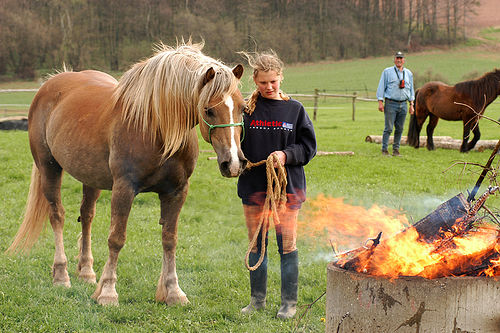

In [9]:
from PIL import Image
from IPython.display import display

# Open and display the image
image = Image.open('10815824_2997e03d76.jpg')
display(image)


In [8]:
def find_index_to_word(predicted_word, tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index == predicted_word:
            find_word = word
            break
        else:
            find_word = 'can not found'
    
    if find_word == 'can not found':
        return 0
    else:
        return find_word
    

In [24]:

def generate_caption(img):
    image_id = img.split('.')
    image_id = image_id[0]

    img = feature_gathered[image_id]
    
    full_text = 'startseq'
    for i in range(maximum_length):

        seq = tokenizer.texts_to_sequences([full_text])[0]
        seq = pad_sequences([seq], maxlen=maximum_length)
        pred_word = np.argmax(model.predict([img, seq], verbose=0))
    
        find_word = find_index_to_word(pred_word, tokenizer)

        if find_word == 0:
            print("Sorry, Can not find word..!")
            break
        elif find_word == 'endseq':
            break

        full_text += " " + find_word
        
    return full_text



#Enter image name:
caption = generate_caption('35506150_cbdb630f4f.jpg')
print(caption)


startseq a man in a red shirt is standing in front of a crowd
